# Test cases fitting real datasets

In this notebook with reproduce some results from the authors of library Max&Sam.

* [GL09] Garlaschelli Loffredo "Generalized Bose-Fermi Statistics and Structural Correlations in Weighted Networks" DOI: 10.1103/PhysRevLett.102.038701
* [Squartini et al 11]  "Analytical maximum-likelihood method to detect patterns in real networks" arxiv:1106.0701
* [Squartini et al 15] "Unbiased sampling of network ensembles", arxiv:1406.1197
* [SG17] Squartini, Garlaschelli  "Maximum-Entropy Networks Pattern Detection, Network Reconstruction and Graph Combinatorics", Springer, 2017.
* [Almog et al 15] Almog, Bird, Garlaschelli "Enhanced Gravity Model of trade: reconciling macroeconomic and network models" arxiv:1506.00348
* [Bianconi et al.09] Bianconi, Pin Marsili, "Assessing the relevance of node features for network structure"    PNAS 106, 11433 (2009).[pnas](http://www.pnas.org/content/early/2009/06/30/0811511106.full.pdf)
* [Ruzzenenti et al.12] Ruzzenenti et al "Spatial effects in real networks: measures, null models, and applications" arxiv:1207.1791
* [Squartini et al. 14] in "Jan Tinbergen’s Legacy for Economic Networks: From the Gravity Model to Quantum Statistics" in F. Abergel et al. (eds.), Econophysics of Agent-Based models,New Economic Windows, DOI 10.1007/978-3-319-00023-7_9
* [Squartini et al.16] "network reconstruction via density sampling" arxiv:1610.05494

	

**Table of contents:**

* [UBCM](#UBCM---Undirected-Binary-Configuration-Model)
* [DBCM](#DBCM)
* [DBCM+spatial](#DBCM+spatial-measures)
* [UWCM](#UWCM)
* [UDCGM](#UDCGM) Undirected Degree-Corrected Gravity Model
* [UECM](#UECM)
* [UECMts+distUBCM](#UECMts+distUBCM) with distance
* [FiUGM](#FiUGM) Fitness Induced Undirected Gravity Model
* [Distance Modulated Undirected Binary CM](#Distance-modulated-Undirected-Binary-Configuration-Model)
* [EGM](#EGM-Enhanced-Gravity-Model)



In [12]:
import numpy as np

from cm_ml.cfg import *
from cm_ml.cmtools import *
from cm_ml.cmtools_spatial import *
from cm_ml.dataset import *
import matplotlib.pyplot as plt
import cm_ml.cm as cm_cy

from scipy import stats
import pandas as pd

import matplotlib.colors as mcolors


## UBCM - Undirected Binary Configuration Model

* ensemble: : UBCM
* $p_{ij}=\frac{x_i x_j}{1+x_i x_j}$
* dataset:

In [2]:
# we reproduce [Squartini et al 11] Fig. 2
g,k,s,A,W = get_us_airport()
k=np.array(k,dtype=np.int32)
sol = solve_eq_UBCM(k)
assert sol.success
P = pij_UBCM(sol.x)
pij_UBCM=P
# knn: theoretical
k_th = k_avg_UBCM(P)
knn_th = knn_avg_UBCM(P,k_th)
# knn: empirical
knn = np.array(g.knn()[0])

# knn_sigma
nsamp=100
n = P.shape[0]
rnd = np.random.rand(n*n*nsamp).reshape((n,n,nsamp))
A_samp=samples_UBCM(P, rnd)
knn_sigma = knn_sigma_sample(A_samp)

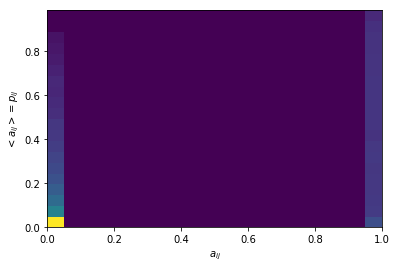

Text(0.5, 0, '$p_{ij}|a_{ij}=1)$')

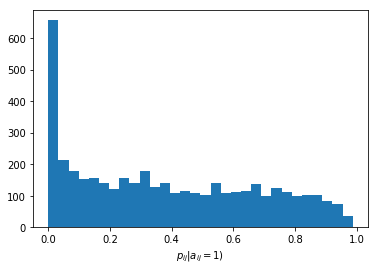

In [6]:
#https://matplotlib.org/gallery/scales/power_norm.html#sphx-glr-gallery-scales-power-norm-py
import matplotlib.colors as mcolors
gamma=0.3
plt.hist2d(A.flatten(),P.flatten(),bins=20,norm=mcolors.PowerNorm(gamma))
plt.xlabel("$a_{ij}$")
plt.ylabel("$<a_{ij}>=p_{ij}$")
plt.show()
idx_nnz = A.flatten()>0
plt.hist(P.flatten()[idx_nnz],30 )
plt.xlabel('$p_{ij}|a_{ij}=1$')

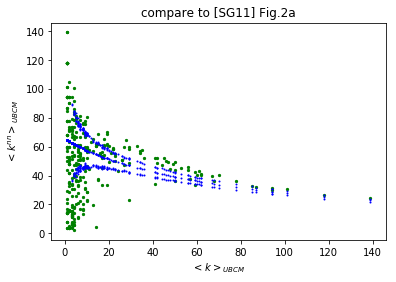

In [13]:
# plot
plt.scatter(k,knn,c='g',s=5  )
plt.scatter(k_th,knn_th, c='b', s=1)
plt.xlabel('$<k>_{UBCM}$')
#plt.ylabel('$\langle k^{nn} \rangle_{UBCM}$')
plt.ylabel('$< k^{nn} >_{UBCM}$')
plt.title('compare to [SG11] Fig.2a')
#
plt.scatter(k_th,knn_th+knn_sigma,c='b',s=1)
plt.scatter(k_th,knn_th-knn_sigma,c='b',s=1)

plt.show()

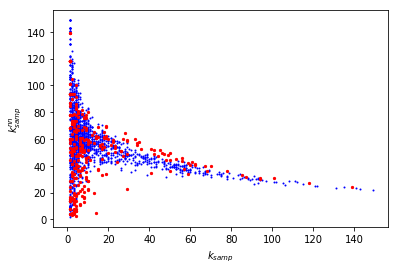

In [14]:
# samples
pij=P
nsamp=10
n = pij.shape[0]
rnd = np.random.rand(n*n*nsamp).reshape((n,n,nsamp))
aij_sample=samples_UBCM(pij, rnd)

ki_sample = sample_k_UDCGM(aij_sample,nsamp, naive=False)
knn_sample = sample_knn_UDCGM(aij_sample,ki_sample,nsamp)
    
plt.scatter(ki_sample[:,0:5].flatten(),knn_sample[:,0:5].flatten(),c='b',s=1)
plt.scatter(k,g.knn()[0], c='r',s=5 )
    #plt.ylim([0,200])
plt.xlabel('$k_{samp}$')
plt.ylabel('$k^{nn}_{samp}$')
plt.show()

Comments:
    
* [SG11] IV.A "in the airport network the randomized curves lie below the real data (except for an opposite trend of  $< k_i^{nn}>$ for low degrees). This means that the real net work is more correlated than the baseline  randomized expectation, and indicates that additional mechanisms producing positive correlations must be present on top of structural effects."

### Comtrade

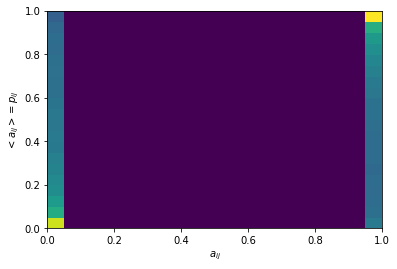

In [13]:
path = '{}/comtrade/yrp-2000.csv'.format(ROOT)
# !!!!!!! SHOULD BE directed=False below.  FIX THAT !!!!!!!!!!!!!!!!!!!!!!!!
g,k,s,A,W = get_comtrade_igraph(path,directed=True) 
k = np.sum(A,axis=0)
sol = solve_eq_UBCM(k)
#print(sol)
#assert sol.success
P = pij_UBCM(sol.x)

gamma=0.3
plt.hist2d(A.flatten(),P.flatten(),bins=20,norm=mcolors.PowerNorm(gamma))
plt.xlabel("$a_{ij}$")
plt.ylabel("$<a_{ij}>=p_{ij}$")
plt.show()

## DBCM

* data: aggregate comtrade year 2000.

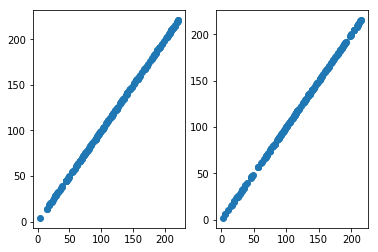

In [7]:
path = '{}/comtrade/yrp-2000.csv'.format(ROOT)
g,k,s,A,W = get_comtrade_igraph(path)
kin=np.array( g.indegree() ,dtype=np.int32 )
kout=np.array( g.outdegree() ,dtype=np.int32 )
nin = kin.shape[0]
nout = kout.shape[0]
sol = solve_eq_DBCM(kin,kout)
assert sol.success

P = pij_DBCM(sol.x,nout,nin)
np.clip(P,0,1)
#assert np.any(P>1)
#assert np.any(P<0)

plt.subplot(1,2,1); plt.scatter(np.sum(P,axis=0),kin); 
plt.subplot(1,2,2); plt.scatter(np.sum(P,axis=1),kout); 

kin_avg,kout_avg = k_avg_DBCM(P);

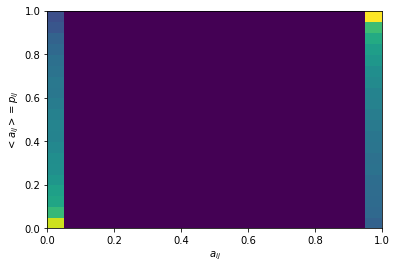

Text(0.5, 0, '$p_{ij}|a_{ij}=1$')

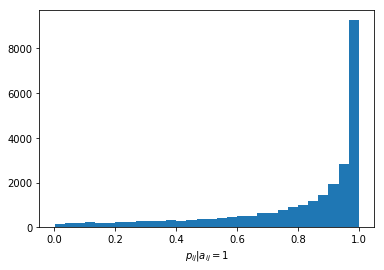

In [8]:
import matplotlib.colors as mcolors
gamma=0.3
plt.hist2d(A.flatten(),P.flatten(),bins=20,norm=mcolors.PowerNorm(gamma))
plt.xlabel("$a_{ij}$")
plt.ylabel("$<a_{ij}>=p_{ij}$")
plt.show()
idx_nnz = A.flatten()>0
plt.hist(P.flatten()[idx_nnz],30 )
plt.xlabel('$p_{ij}|a_{ij}=1$')

### ANND in/in , ANND out/ou

Rappel [SG17]:
    
*  $k_i^{nn,out/out} =\frac{\sum_{j \neq i} a_{ij} k_j^{out} }{k_i^{out}}$
*  $k_i^{nn,in/in} =\frac{\sum_{j \neq i} a_{ji} k_j^{in} }{k_i^{in}}$

In [7]:
# empirical (no such function in igraph)
knn_in,knn_out = knn_avg_DBCM(np.array(A.data),kin,kout)
# theor
knn_avg_in,knn_avg_out = knn_avg_DBCM(P,kin_avg,kout_avg)

Text(0.5, 1.0, 'compare to [SG17] Fig.3.3')

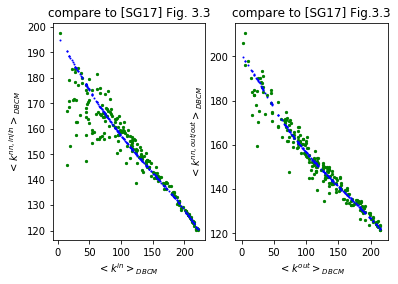

In [8]:
plt.subplot(1,2,1)
plt.scatter(kin,knn_in,c='g',s=5  )
plt.scatter(kin_avg,knn_avg_in, c='b', s=1)

plt.xlabel('$<k^{in}>_{DBCM}$')
#plt.ylabel('$\langle k^{nn} \rangle_{UBCM}$')
plt.ylabel('$< k^{nn,in/in} >_{DBCM}$')
plt.title('compare to [SG17] Fig. 3.3')


plt.subplot(1,2,2)
plt.scatter(kout,knn_out,c='g',s=5  )
plt.scatter(kout_avg,knn_avg_out, c='b', s=1)

plt.xlabel('$<k^{out}>_{DBCM}$')
#plt.ylabel('$\langle k^{nn} \rangle_{UBCM}$')
plt.ylabel('$< k^{nn,out/out} >_{DBCM}$')
plt.title('compare to [SG17] Fig.3.3')


# DBCM+spatial measures

see [Ruzzenenti et al.12] 


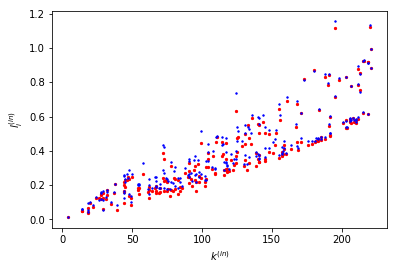

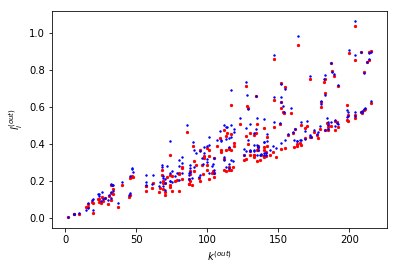

In [5]:
  
    path = '{}/comtrade/yrp-2000.csv'.format(ROOT)
    g,k,s,A,W,Dij = get_comtrade_distance_igraph(path,directed=True)
    # fit DBCM 
    #kin=np.array( g.indegree() ,dtype=np.int32 )
    #kout=np.array( g.outdegree() ,dtype=np.int32 )
    kin  = np.sum(A,axis=0)
    kout = np.sum(A,axis=1)    
    nin = kin.shape[0]
    nout = kout.shape[0]
    sol = solve_eq_DBCM(kin,kout)
    # fit DRGM ..
    # fit DRCM ..
    assert sol.success
    P = pij_DBCM(sol.x,nout,nin)
    kin_DBCM  = np.sum(P,axis=0)
    kout_DBCM = np.sum(P,axis=1)
    l_i_in, l_i_out = l_i(A,Dij) 
    l_i_in_DBCM, l_i_out_DBCM = l_i(P,Dij) 
    
    plt.scatter(kin,l_i_in,c='r',s=5);
    plt.scatter(kin_DBCM,l_i_in_DBCM,c='b',s=2);
    plt.xlabel('$k^{(in)}$')
    plt.ylabel('$l_i^{(in)}$')
    plt.show()
    plt.scatter(kout,l_i_out,c='r',s=5);
    plt.scatter(kout_DBCM,l_i_out_DBCM,c='b',s=2);
    plt.xlabel('$k^{(out)}$')
    plt.ylabel('$l_i^{(out)}$')
    plt.show()
    

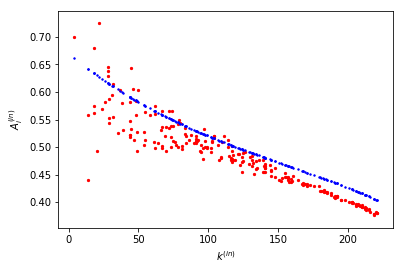

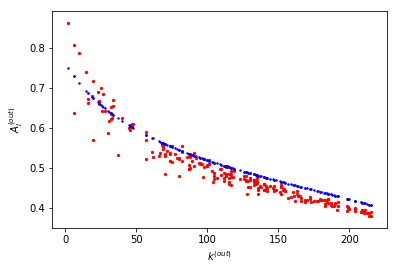

In [6]:
    A_in,A_out = assortativity(A,l_i_in,l_i_out,k_in=kin,k_out=kout)
    A_in_DBCM,A_out_DBCM = assortativity(P,l_i_in_DBCM,l_i_out_DBCM,
                            k_in=kin_DBCM,k_out=kout_DBCM)
    
    plt.scatter(kin,A_in,c='r',s=5);
    plt.scatter(kin_DBCM,A_in_DBCM,c='b',s=2);
    plt.xlabel('$k^{(in)}$')
    plt.ylabel('$A_i^{(in)}$')
    plt.show()
    plt.scatter(kout,A_out,c='r',s=5);
    plt.scatter(kout_DBCM,A_out_DBCM,c='b',s=2);
    plt.xlabel('$k^{(out)}$')
    plt.ylabel('$A_i^{(out)}$')
    plt.show()
    

Comments:

   * $l_i = f(k_i)$ reproduces well Fig.8-9
   * $A_i = f(k_i)$ reproduces well Fig.10-11


TODO: 

   * fit DRGM ..
   * fit DRCM ..

# UWCM

* ensemble: : UWCM  - Undirected Weighted Configuration Model
* $q_{ij}(w)=(x_i x_j)^w(1-x_i x_j)$      cf [GL09] eq (15bis)
* $p_{ij}=x_i x_j$  cf [GL09] eq (15bis)
* $\langle w_{ij}\rangle= \frac{x_i x_j}{1-x_i x_j}$ cf [GL09] eq (18)
* dataset:

In [9]:
# solve the UWCM
#g,k,s,A = get_us_airport(); factor=1.0
path = '{}/comtrade/yrp-2000.csv'.format(ROOT)
g,k,s,A,W = get_comtrade_igraph(path, directed=False); factor= 1E-11
#print(s)

assert not g.is_directed()
W = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute='weight', default=0, eids=False)
W = factor/(len(k))* np.array(W.data)
s= factor*np.array( s)
sol = solve_eq_UWCM(s)
assert sol.success
P = pij_UWCM(sol.x)
W_avg_theor =  wij_avg_UWCM(P)

Generating samples and taking the sample average.

In [10]:
#  samples
nsamp = 1000
n = P.shape[0]
W_samp=np.zeros((n,n,nsamp),dtype=np.long) 
cm_cy.samples_UWCM( P, W_samp) 
s_avg, W_flat_avg= sample_avg_UWCM(W_samp)


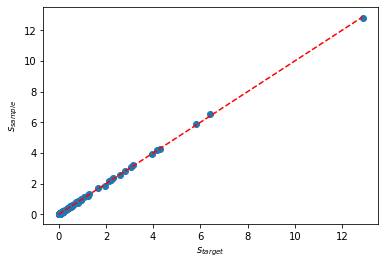

In [11]:
# plot strength again
plt.scatter(s,s_avg); 
plt.xlabel("$s_{target}$")
plt.ylabel("$s_{sample}$")
plt.plot( [s.min(),s.max()],[s.min(),s.max()], 'r--')
plt.show()

Also the weights

In [12]:
# W against W_samp 
#W_rep = np.tile(np.array(W.data),[nsamp,1]).reshape(n,n,nsamp) # WRONG
nsamp_small=30
W_rep = np.zeros((n,n,nsamp_small))
for i in range(nsamp_small):W_rep[:,:,i]=W.copy() # SLOW !!!!!!!


plt.scatter(W_rep.flatten(), W_samp.flatten())
plt.xlabel("wij")
plt.ylabel("wij_samp")
plt.show()

IndexError: index 30 is out of bounds for axis 2 with size 30

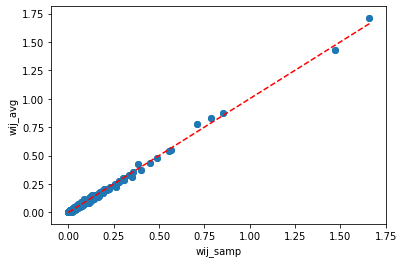

In [13]:
# wij (see [Squartini et al 15] Fig.4)
plt.scatter(W_flat_avg, W_avg_theor.flatten() )
plt.plot( [W_flat_avg.min(),W_flat_avg.max()],[W_flat_avg.min(),W_flat_avg.max()], 'r--')
plt.ylabel("wij_avg")
plt.xlabel("wij_samp")
plt.show()

## clustering

????

## average nearest neighbors indicators

Average nearest neighbors strength:

* $s^{nn}_i=\frac{ \sum_{j \neq i} a_{ij} s_j }{k_i}$, see [SG17] (3.28)
* $<s^{nn}>_i=\frac{ \sum_{j \neq i} p_{ij} s_j }{<k_i>}$, see [SG17] (3.29) since $<s_j>=s_j$ under the UWCM.


Expectation value of the weighted ANND, see [SG11]:
    
* $\tilde{k}^{nn}_i=\frac{ \sum_{j \neq i} \sum_{k \neq j} w_{ij} w_{jk} }{W \sum_{j \neq i} w_{ij} }$, see [SG11] (19)   with $W=\sum_{i<j} w_{ij}$
* $< \tilde{k}^{nn}_i > =\frac{ \sum_{j \neq i} \sum_{k \neq j} <w_{ij}> <w_{jk}> }{W \sum_{j \neq i} <w_{ij}> }$, see [SG11] (B.28)

0.0
0.0


/home/aurelien/local/git/cm_ml/cmtools.py:774: RuntimeWarning: invalid value encountered in true_divide
  snn = snn/k


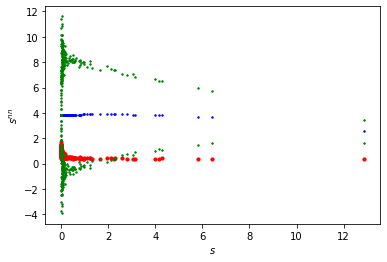

In [14]:
# empirical snn
k=np.array( k )
snn_ = snn(np.array(A.data),k,s)
plt.xlabel("$s$")
plt.ylabel("$s^{nn}$")
plt.scatter(s,snn_,c='r',s=10)

# solve UWCM
sol = solve_eq_UWCM(s) 
assert sol.success
P = pij_UWCM(sol.x)
# clip
print(np.sum(1*P<0)/np.prod(P.shape))
print(np.sum(1*P>=1)/np.prod(P.shape))
np.clip(P,0,1)
# theoretical snn
k_avg_ = k_avg_UBCM(P)  ;
snn_avg = snn(P,k_avg_,s)  
plt.scatter(s,snn_avg,c='b',s=2)

# snn_sigma
snn_sigma = snn_sigma_sample(W_samp,directed=False)
plt.scatter(s,snn_avg+snn_sigma,c='g',s=2)
plt.scatter(s,snn_avg-snn_sigma,c='g',s=2)

#plt.ylim((0,2.5))
plt.show()

# !!!!!!!!!! REDO WITH ITN, reproduce [SG17] Fig. 3.11


Commentaires:

* net = airport: pas d'offset
* net = WTN: il y a un offset. Pourquoi ?  
   *  Validation: [SG17] 3.4.1 trouve plat puis décroissant.

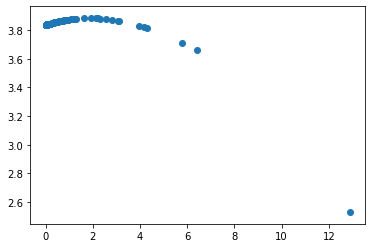

In [15]:
plt.scatter(s,snn_avg)
plt.show()

Comments: 
    
*  data=aiport:  fit is not convincing for this dataset. 
*  data=WTN : 
* Compare to discussions:
    *  [SG11] IV D: "empirical trend first increase and then decrease (airport network)" ; "null model (...) is not flat and displays a not easily characterizable increasing behavior"
    *  [SG17] §3.4.1

/home/aurelien/local/git/cm_ml/cmtools.py:855: RuntimeWarning: invalid value encountered in true_divide
  wknn = wknn/s


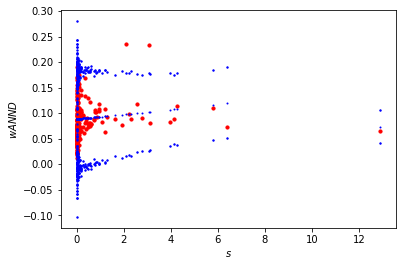

In [16]:
# weighted ANND
#g,k,s,A = get_us_airport_igraph(path='data/USAir97.net')
wknn_ = wknn(np.array(W.data),s)

wknn_theor = wknn(W_avg_theor,s)

wknn_sigma = wknn_sigma_sample(W_samp,directed=False)    
 

plt.scatter(s,wknn_,c='r',s=10)
plt.scatter(s,wknn_theor,c='b',s=1)
plt.scatter(s, wknn_theor+wknn_sigma,c='b',s=2)
plt.scatter(s, wknn_theor-wknn_sigma,c='b',s=2)
plt.xlabel("$s$")
plt.ylabel("$wANND$")
plt.show()




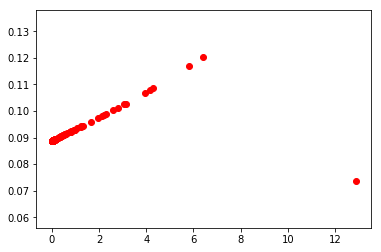

In [32]:
plt.scatter(s,wknn_theor,c='r')

In [17]:
df_ = pd.DataFrame(data = {'names':range(n),'k':k,'s':s,'snn':snn_,'wknn':wknn_,'wknn_sigma':wknn_sigma})
print(df_)

     names    k         s       snn      wknn  wknn_sigma
0        0  116  0.007299  0.718189  0.034780    0.147119
1        1  133  0.013507  0.638428  0.051088    0.129408
2        2  196  0.513298  0.437784  0.080338    0.090165
3        3  219  0.932233  0.390659  0.104396    0.091728
4        4  211  0.846197  0.405870  0.093321    0.088259
..     ...  ...       ...       ...       ...         ...
221    221   15  0.000014  1.333192  0.134270         NaN
222    222   27  0.000188  1.463417  0.041610         NaN
223    223   16  0.000004  0.401174  0.012595         NaN
224    224  116  0.001638  0.722310  0.075477    0.020406
225    225    5  0.000003  0.892048  0.029040         NaN

[226 rows x 6 columns]


In [ ]:
# clustering

# UDCGM

Undirected Degree-Corrected Gravity Model: [Squartini et al.16] 

No distance here.

First WITHOUT CORRECTION (see [SG17] 4.3.2).

In [18]:
PATH_COMTRADE= '/home/aurelien/local/data/comtrade'
path = '{}/yrp-2000.csv'.format(PATH_COMTRADE)
g,k,s,A,W = get_comtrade_igraph(path,directed=False)
assert not g.is_directed()
factor=1E-9

s=factor * np.array( s)
#s=np.log(factor* np.array( s))
k=np.array( g.degree() )
A = np.array(A.data)
n = s.shape[0]
sol=solve_DCGM(s,k=k,z0=None)#,jac=ficm_cy._jac_DCGM)
assert sol.success
z = sol.x[0]
P = pij_DCGM(s,z)

# sample
wij_sample = sample_wij_DCGM(P,s,nsamp=300,correction=False)
aij_sample = 1.*(wij_sample>0)
aij_avg = aij_avg_DCGM(wij_sample)
wij_avg= wij_avg_DCGM(wij_sample)
k_avg = np.sum(aij_avg,axis=0)	
s_avg = np.sum(wij_avg,axis=0)
snn_avg = snn(P,k_avg,s_avg)

# knn
knn_avg = knn_avg_UBCM(P,k_avg)
knn_sigma = knn_sigma_sample(aij_sample,directed=False)
# snn
snn_sigma = snn_sigma_sample(wij_sample,directed=False)


/home/aurelien/local/git/cm_ml/cmtools.py:103: RuntimeWarning: divide by zero encountered in true_divide
  Wij = Wij/P
/home/aurelien/local/git/cm_ml/cmtools.py:774: RuntimeWarning: divide by zero encountered in true_divide
  snn = snn/k


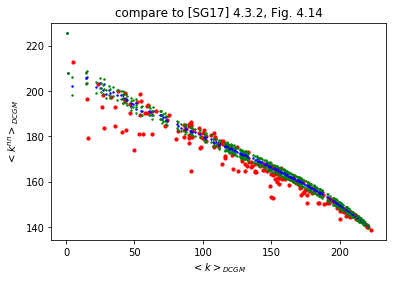

In [19]:
plt.scatter(k,g.knn()[0], c='r',s=10 )
plt.scatter(k_avg, knn_avg, c='b',s=2)
plt.scatter(k_avg, knn_avg+knn_sigma, c='g',s=2)
plt.scatter(k_avg, knn_avg-knn_sigma, c='g',s=2)

plt.xlabel('$<k>_{DCGM}$')
plt.ylabel('$< k^{nn} >_{DCGM}$')
plt.title('compare to [SG17] 4.3.2, Fig. 4.14')

plt.show()

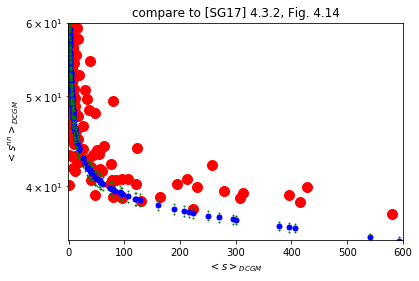

In [20]:
plt.semilogy(s, snn(A,k,s) , 'ro',markersize=10 ) 
plt.semilogy(s_avg, snn_avg , 'b.',markersize=10 ) 
plt.semilogy(s_avg, snn_avg+snn_sigma, 'g.',markersize=2 ) 
plt.semilogy(s_avg,snn_avg-snn_sigma , 'g.',markersize=2 ) 
plt.xlabel('$<s>_{DCGM}$')
plt.ylabel('$< s^{nn} >_{DCGM}$')
plt.title('compare to [SG17] 4.3.2, Fig. 4.14')
plt.xlim([-1,600])
plt.ylim([35,60])
plt.show()

Check the effect of **correction**, with airport data.

/home/aurelien/local/git/cm_ml/cmtools.py:127: RuntimeWarning: divide by zero encountered in true_divide
  Wij = (Wij+Wij_correc)/P
/home/aurelien/local/git/cm_ml/cmtools.py:129: RuntimeWarning: divide by zero encountered in true_divide
  Wij = Wij/P


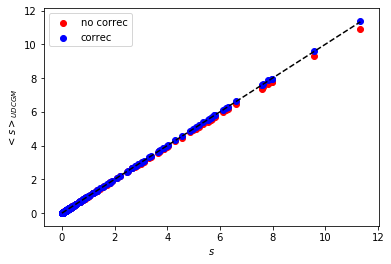

In [2]:
g,k,s,A,W = get_us_airport(); 
if np.all(s==0):
	print('error reading pajek file...')
	net,k,s,A=get_us_airport(path='data/USAir97.net',backend='nx')
s=np.array( s)
k=np.array( g.degree() )
A = np.array(A.data)
n = s.shape[0]
sol=solve_UDCGM(s,k=k,z0=0.0,jac=None)
assert sol.success
z = sol.x[0]
P = pij_UDCGM(s,z)

# get samples
nsamp=1000
wij_sample_correc = sample_wij_UDCGM(P,s,nsamp=nsamp,correction=True)
wij_sample_nocorrec = sample_wij_UDCGM(P,s,nsamp=nsamp,correction=False)
    
wij_avg_correc= wij_avg_UDCGM(wij_sample_correc)
wij_avg_nocorrec= wij_avg_UDCGM(wij_sample_nocorrec)
s_avg_correc = np.sum(wij_avg_correc,axis=0)
s_avg_nocorrec = np.sum(wij_avg_nocorrec,axis=0)   

#plot
plt.scatter(s,s_avg_nocorrec,color='r',label='no correc');
plt.scatter(s,s_avg_correc,color='b',label='correc');
M= np.max(s)
plt.plot([0,M],[0,M],'k--')
plt.xlabel('$s$')
plt.ylabel('$<s>_{UDCGM}$')
plt.legend()
plt.show()

## DDCGM Directed Degree-Corrected Gravity Model

# UECM

Reproduit weigth et degree mais pas de facteurs dyadiques (e.g. distance)

Extended Configuration Model, avec 2-step algo ([Almog15b]

cf [SG17] 4.2 ; 'dramatic improvement'


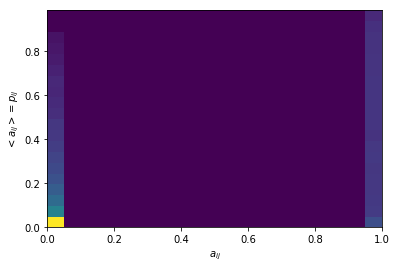

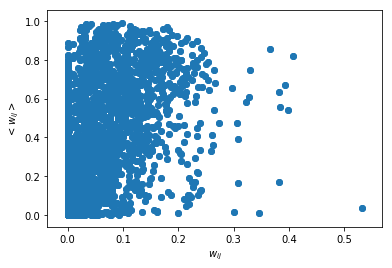

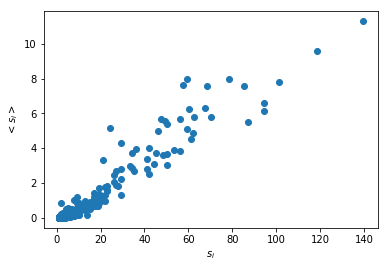

In [8]:
import matplotlib.colors as mcolors
g,k,s,A,W = get_us_airport();
pij_ts,wij_avg = solve_UECM_two_step(k,s,loops=1000,precision=10e-3)
gamma=0.3
plt.hist2d(A.flatten(),pij_ts.flatten(),bins=20,norm=mcolors.PowerNorm(gamma))
plt.xlabel("$a_{ij}$")
plt.ylabel("$<a_{ij}>=p_{ij}$")
plt.show()
plt.scatter(W.flatten(),wij_avg ); 
plt.xlabel("$w_{ij}$")
plt.ylabel("$<w_{ij}>$")
plt.show()
plt.scatter(np.sum(wij_avg,axis=0),s )
plt.xlabel("$s_{i}$")
plt.ylabel("$<s_{i}>$")

plt.show()

Comment:
    
   * problem with $p_{ij}$

In [15]:
# regress s, s_avg
slope, intercept, r_value, p_value, std_err = stats.linregress(s,np.sum(wij_avg,axis=0))

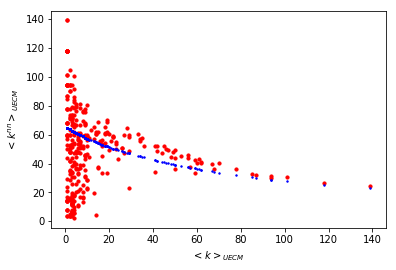

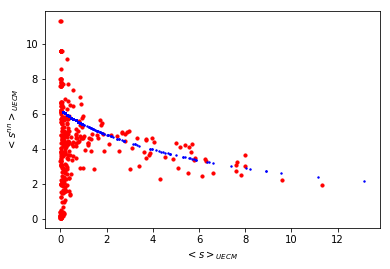

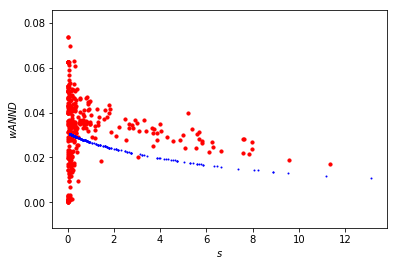

In [16]:
knn_ = knn_avg_UBCM(A,k)
snn_ = snn(A,k,s)
wknn_ = wknn(W,s)

k_avg = np.sum(pij_ts,axis=0)
s_avg = np.sum(wij_avg,axis=0)
wknn_avg = wknn(wij_avg,s_avg/slope)

knn_avg = knn_avg_UBCM(pij_ts,k_avg) 
snn_avg = snn(pij_ts,k_avg, s_avg/slope)

plt.scatter(k,knn_, c='r',s=10 )
plt.scatter(k_avg, knn_avg, c='b',s=2)
plt.xlabel('$<k>_{UECM}$')
plt.ylabel('$<k^{nn} >_{UECM}$')
plt.show()

plt.scatter(s, snn_ , c='r',s=10 )
plt.scatter(s_avg/slope, snn_avg, c='b',s=2)
plt.xlabel('$<s>_{UECM}$')
plt.ylabel('$<s^{nn} >_{UECM}$')
plt.show()

plt.scatter(s,wknn_,c='r',s=10)
plt.scatter(s_avg/slope,wknn_avg,c='b',s=1)
plt.xlabel("$s$")
plt.ylabel("$wANND$")
plt.show()


Comments:
    
   * linear fit ok between $s_{i}$ and $<s_{i}>$. Slope $\sim 10$
   * fit is ok for $k^{nn}$ and $s^{nn}$
   * there is an offset for $wk^{nn}$.

In [17]:
""" NOT IMPLEMENTED !! 
#sample  
nsamp = 100
n = pij_ts.shape[0]
wij_samp=np.zeros((n,n,nsamp),dtype=np.long) 
#!!!!
aij_sample = 1.*(wij_samp>0)
"""

In [20]:
"""  NOT IMPLEMENTED !! 
ki_sample = sample_k_UDCGM(aij_sample,nsamp, naive=False)
knn_sample = sample_knn_UDCGM(aij_sample,ki_sample,nsamp)
si_sample= sample_s(wij_samp,nsamp) 
snn_sample= sample_snn(aij_sample,ki_sample,si_sample,nsamp)   
"""

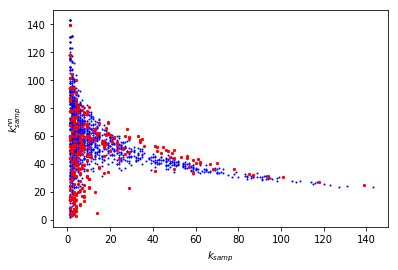

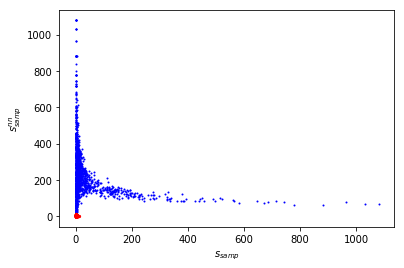

In [21]:
""" NOT IMPLEMENTED !! 
#plot
plt.scatter(ki_sample[:,0:5].flatten(),knn_sample[:,0:5].flatten(),c='b',s=1)
plt.scatter(k,g.knn()[0], c='r',s=5 )
    #plt.ylim([0,200])
plt.xlabel('$k_{samp}$')
plt.ylabel('$k^{nn}_{samp}$')
plt.show()

plt.scatter(si_sample[:,0:5].flatten(),snn_sample[:,0:5].flatten(),c='b',s=1)
plt.scatter(s, snn_, c='r',s=5 )
    #plt.ylim([0,200])
plt.xlabel('$s_{samp}$')
plt.ylabel('$s^{nn}_{samp}$')
plt.show()"""

# UECMts+distUBCM

with distance 

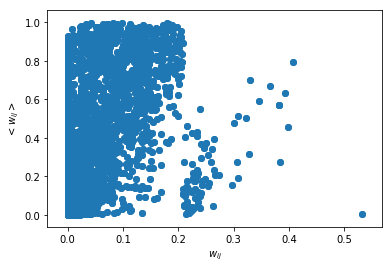

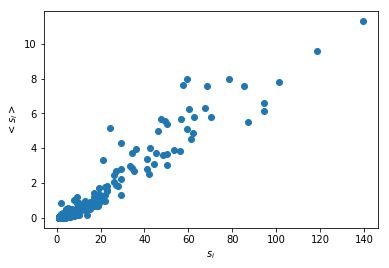

In [5]:
# without distance
g,k,s,A,W,D = get_us_airport_distance_igraph(path='data/USAir97.net');

# distUBCM
nbins=10
class_dij,B_d,bin_edges = get_classes(D,A,bins=nbins)
dij=D; Nd=nbins
pij_distUBCM,z,Wd = solve_lagrangian_distance(k,dij,class_dij,B_d,Nd,loops=1000,precision=10e-2)

pij_ts,wij_avg = solve_UECM_two_step(k,s,pij_ts=pij_distUBCM,loops=1000,precision=10e-3)
plt.scatter(W.flatten(),wij_avg ); 
plt.xlabel("$w_{ij}$")
plt.ylabel("$<w_{ij}>$")
plt.show()
plt.scatter(np.sum(wij_avg,axis=0),s )
plt.xlabel("$s_{i}$")
plt.ylabel("$<s_{i}>$")

plt.show()

In [6]:
# regress s, s_avg
slope, intercept, r_value, p_value, std_err = stats.linregress(s,np.sum(wij_avg,axis=0))

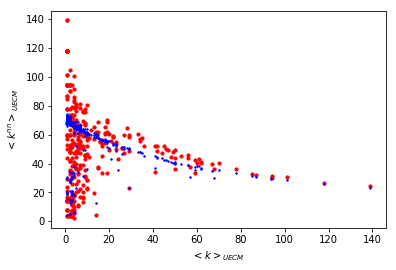

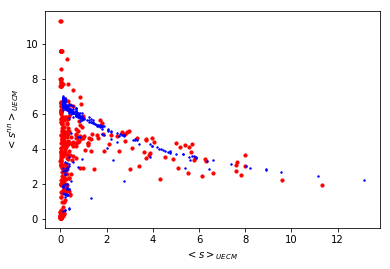

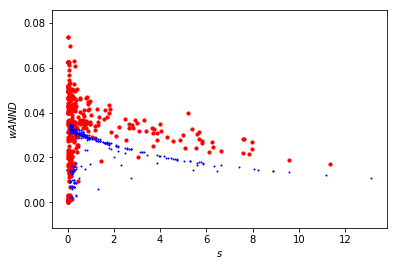

In [7]:
knn_ = knn_avg_UBCM(A,k)
snn_ = snn(A,k,s)
wknn_ = wknn(W,s)

k_avg = np.sum(pij_ts,axis=0)
s_avg = np.sum(wij_avg,axis=0)
wknn_avg = wknn(wij_avg,s_avg/slope)

knn_avg = knn_avg_UBCM(pij_ts,k_avg) 
snn_avg = snn(pij_ts,k_avg, s_avg/slope)

plt.scatter(k,knn_, c='r',s=10 )
plt.scatter(k_avg, knn_avg, c='b',s=2)
plt.xlabel('$<k>_{UECM}$')
plt.ylabel('$<k^{nn} >_{UECM}$')
plt.show()

plt.scatter(s, snn_ , c='r',s=10 )
plt.scatter(s_avg/slope, snn_avg, c='b',s=2)
plt.xlabel('$<s>_{UECM}$')
plt.ylabel('$<s^{nn} >_{UECM}$')
plt.show()

plt.scatter(s,wknn_,c='r',s=10)
plt.scatter(s_avg/slope,wknn_avg,c='b',s=1)
plt.xlabel("$s$")
plt.ylabel("$wANND$")
plt.show()

# FiUGM

Fitness Induced Undirected Gravity Model

  
[Squartini et al. 14] see eq(9.18)

$p_{ij}=\frac{z GDP_i GDP_j \exp{-\gamma d_{ij}}}{1+ z GDP_i GDP_j \exp{-\gamma d_{ij}}}$


Uses the distance.

cf [Bianconi et al.09]

In [8]:
g,k,s,A,W,D = get_us_airport_distance_igraph(path='data/USAir97.net');
sol = solve_FiUGM(k,D,x0=[0.1,1.],fun='exp')
u,v = sol.x[0],sol.x[1]
pij = pij_FiUGM(k,D,u,v,fun='exp')
assert not np.any(pij>=1)
assert not np.any(pij<0)

k_avg = k_avg_UBCM(pij)
knn_avg = knn_avg_UBCM(pij,k_avg) 

/home/aurelien/.local/lib/python3.5/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


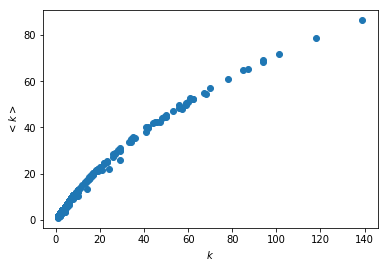

In [9]:
plt.scatter(k,k_avg);
plt.xlabel('$k$')
plt.ylabel('$<k>$')
plt.show()


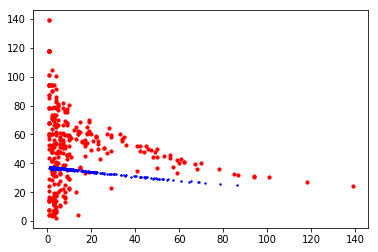

In [10]:
plt.scatter(k,g.knn()[0], c='r',s=10 )
plt.scatter(k_avg, knn_avg, c='b',s=2)

plt.show()

/home/aurelien/local/git/cm_ml/cmtools.py:1015: RuntimeWarning: divide by zero encountered in double_scalars
  knn[i]= 1./k[i] * np.dot(P[i,:], mysum)
/home/aurelien/local/git/cm_ml/cmtools.py:1015: RuntimeWarning: invalid value encountered in double_scalars
  knn[i]= 1./k[i] * np.dot(P[i,:], mysum)


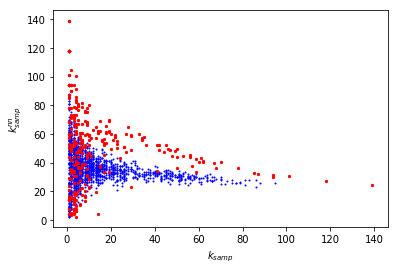

In [11]:
# samples
nsamp=10
n = pij.shape[0]
rnd = np.random.rand(n*n*nsamp).reshape((n,n,nsamp))
aij_sample=samples_UBCM(pij, rnd)

ki_sample = sample_k_UDCGM(aij_sample,nsamp, naive=False)
knn_sample = sample_knn_UDCGM(aij_sample,ki_sample,nsamp)
    
plt.scatter(ki_sample[:,0:5].flatten(),knn_sample[:,0:5].flatten(),c='b',s=1)
plt.scatter(k,g.knn()[0], c='r',s=5 )
    #plt.ylim([0,200])
plt.xlabel('$k_{samp}$')
plt.ylabel('$k^{nn}_{samp}$')
plt.show()

# Distance-modulated Undirected Binary Configuration Model

Uses the distance.

cf [Bianconi et al.09]

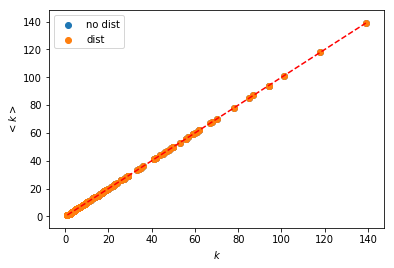

In [4]:
# without distance
g,k,s,A,W,D = get_us_airport_distance_igraph(path='data/USAir97.net');
z = solve_lagrangian_k(k,loops=1000,precision=10e-2)
zz = np.outer(z,z)
np.fill_diagonal(zz,0)
pij = zz/(1.+zz)
k_avg = np.sum(pij,axis=0)
    
# with distance    
nbins=10
class_dij,B_d,bin_edges = get_classes(D,A,bins=nbins)
dij=D; Nd=nbins
pij_dist,z,W = solve_lagrangian_distance(k,dij,class_dij,B_d,Nd,loops=1000,precision=10e-2)
k_avg_dist = np.sum(pij,axis=0)
    
plt.scatter(k,k_avg, label='no dist');
plt.scatter(k,k_avg_dist, label='dist');
plt.plot( [k.min(),k.max()],[k.min(),k.max()], 'r--')
plt.legend()
plt.xlabel('$k$')
plt.ylabel('$<k>$')
plt.show()

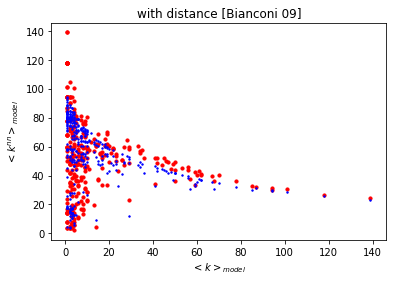

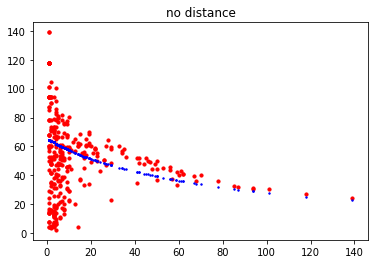

In [8]:
knn_avg = knn_avg_UBCM(pij,k_avg_dist) 
knn_avg_dist = knn_avg_UBCM(pij_dist,k_avg_dist) 

plt.scatter(k,g.knn()[0], c='r',s=10 )
plt.scatter(k_avg_dist, knn_avg_dist, c='b',s=2)
plt.xlabel('$<k>_{model}$')
plt.ylabel('$< k^{nn} >_{model}$')
plt.title('with distance [Bianconi 09]')
plt.show()
plt.scatter(k,g.knn()[0], c='r',s=10 )
plt.scatter(k_avg, knn_avg, c='b',s=2)
plt.title('no distance')
plt.show()

/home/aurelien/local/git/cm_ml/cmtools.py:1018: RuntimeWarning: divide by zero encountered in double_scalars
  knn[i]= 1./k[i] * np.dot(P[i,:], mysum)
/home/aurelien/local/git/cm_ml/cmtools.py:1018: RuntimeWarning: invalid value encountered in double_scalars
  knn[i]= 1./k[i] * np.dot(P[i,:], mysum)


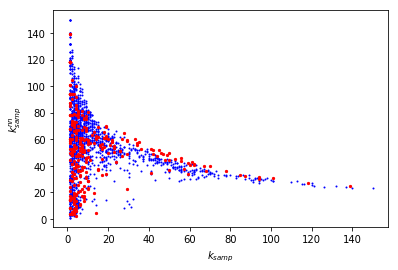

In [5]:
# samples
nsamp=10
n = pij.shape[0]
rnd = np.random.rand(n*n*nsamp).reshape((n,n,nsamp))
aij_sample=samples_UBCM(pij, rnd)

ki_sample = sample_k_UDCGM(aij_sample,nsamp, naive=False)
knn_sample = sample_knn_UDCGM(aij_sample,ki_sample,nsamp)
    
plt.scatter(ki_sample[:,0:5].flatten(),knn_sample[:,0:5].flatten(),c='b',s=1)
plt.scatter(k,g.knn()[0], c='r',s=5 )
    #plt.ylim([0,200])
plt.xlabel('$k_{samp}$')
plt.ylabel('$k^{nn}_{samp}$')
plt.show()

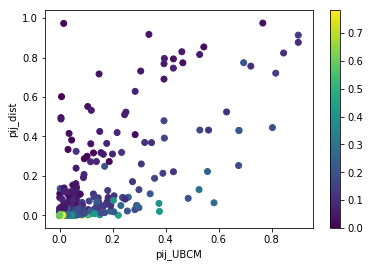

In [12]:
plt.scatter(pij_UBCM.flatten()[0::100], pij_dist.flatten()[0::100], c=D.flatten()[0::100]); 
plt.xlabel('pij_UBCM')
plt.ylabel('pij_dist')
plt.colorbar()
plt.show()

Commentaire:
    
*   très proche de UBCM.

## EGM Enhanced Gravity Model

EGM ([Almog et al. 15b] 1506.00348) reproduit weight, ,distance, link density, mais pas degree.

/home/aurelien/local/git/cm_ml/cmtools.py:185: OptimizeWarning: Unknown solver options: maxiter
  sol_F  = root(fun=fun, args=args, x0=z0,method=method,jac=jac,options=options)


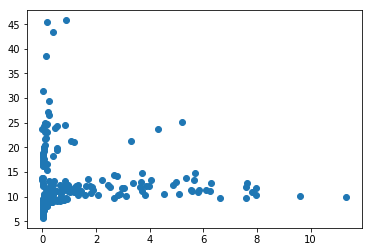

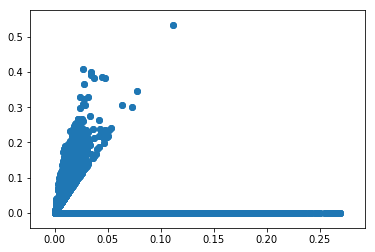

In [4]:
g,k,s,A,W,D = get_us_airport_distance_igraph(path='data/USAir97.net');
L=np.sum(k)
np.fill_diagonal(D,1.0)
factor = 1.
#s=factor*s
#W = factor/s.shape[0]*W
maxiter = 1000
z0=[0.5,0.5,0.5]
sol_F,sol_G=solve_UEGM(W,A,s,D,L,z0=z0,method='hybr',jac=None,
    					options={'maxiter':maxiter},
							fun=eq_UEGM_GDP)
delta= sol_G.x[0]
c    = sol_F.x[0]    
alpha= sol_F.x[1]    
gamma= sol_F.x[2]    							
xij,yij=x_y_UEGM_GDP(s, delta,c,alpha,gamma,D)	
pij = pij_UEGM(xij,yij)						
assert not np.any(pij>=1)
assert not np.any(pij<0)
#print(np.sum(1*pij<0)/np.prod(pij.shape) )
#print(np.sum(1*pij>=1.)/np.prod(pij.shape) )

wij_avg = wij_avg_UEGM(pij,yij)
s_avg = np.sum(wij_avg,axis=0)
plt.scatter(s,s_avg); plt.show()  # BAD FIT !!!!!!!!!!!
plt.scatter( wij_avg, W.flatten()); plt.show()
#plt.scatter(np.log(wij_avg.flatten()), np.log(W.flatten())  );

Commentaire:
    
    * fit not so bad except for outliers.

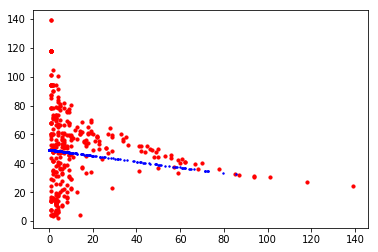

In [6]:
k_avg = k_avg_UBCM(pij)
knn_avg = knn_avg_UBCM(pij,k_avg)
    
plt.scatter(k,g.knn()[0], c='r',s=10 )
plt.scatter(k_avg, knn_avg, c='b',s=2)
plt.show()

Comment:
    
* Fit is ok.

In [2]:
s_avg = np.sum(wij_avg,axis=0)
snn_avg = snn(pij,k_avg,s_avg)
#snn_avg = snn(pij,k,s)

plt.scatter(s, snn(A,k,s) , c='r',s=10 )
plt.scatter(s_avg, snn_avg, c='b',s=2)
plt.show()

NameError: name 'np' is not defined

Comment:
    
  * fit is **bad**. why ?
  * TODO: sigma !!!!